In [84]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

#import name list that we scrapped
names = open("/home/tamir/workspace/makemore/name_scrapper/extracted_values.txt", "r").read().splitlines()
#normalize the text converting uppercase to lowercase
names = [name.lower() for name in names]


chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

N = torch.zeros((36, 36), dtype=torch.int32)


for name in names:
    chs = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]

        N[ix1,ix2] += 1

(-0.5, 35.5, 35.5, -0.5)

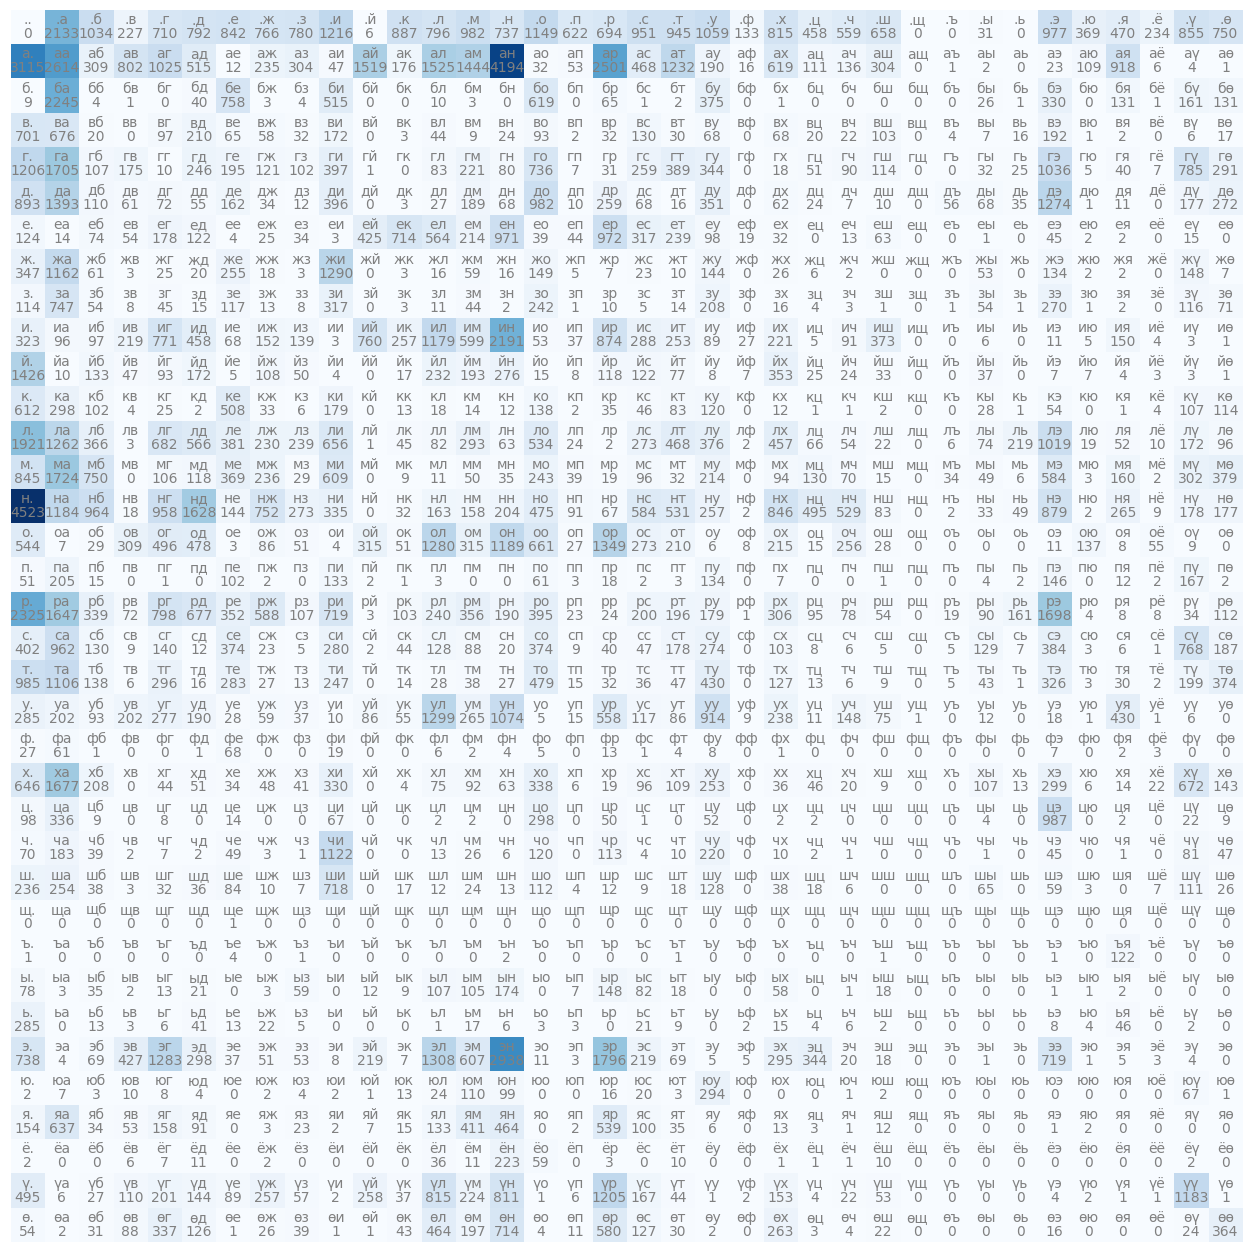

In [17]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(36):
    for j in range(36):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
plt.axis('off')

In [18]:
N[0, :]

tensor([   0, 2133, 1034,  227,  710,  792,  842,  766,  780, 1216,    6,  887,
         796,  982,  737, 1149,  622,  694,  951,  945, 1059,  133,  815,  458,
         559,  658,    0,    0,   31,    0,  977,  369,  470,  234,  855,  750],
       dtype=torch.int32)

In [60]:
#probability distribution
p = (N[0] + 1).float()
p = p / p.sum()
p

tensor([4.2242e-05, 9.0145e-02, 4.3721e-02, 9.6312e-03, 3.0034e-02, 3.3498e-02,
        3.5610e-02, 3.2400e-02, 3.2991e-02, 5.1409e-02, 2.9570e-04, 3.7511e-02,
        3.3667e-02, 4.1524e-02, 3.1175e-02, 4.8579e-02, 2.6317e-02, 2.9358e-02,
        4.0215e-02, 3.9961e-02, 4.4777e-02, 5.6605e-03, 3.4470e-02, 1.9389e-02,
        2.3656e-02, 2.7838e-02, 4.2242e-05, 4.2242e-05, 1.3518e-03, 4.2242e-05,
        4.1313e-02, 1.5630e-02, 1.9896e-02, 9.9269e-03, 3.6159e-02, 3.1724e-02])

In [61]:
#the reason we're using manual seed with certian number is that it will garentue that we will get same number
g = torch.Generator().manual_seed(214719)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
print(itos[idx])

о


In [62]:
P = N.float()
P /= P.sum(1, keepdim=True)
P.shape

torch.Size([36, 36])

In [63]:
#the reason we're using manual seed with certian number is that it will garentue that we will get same number
g = torch.Generator().manual_seed(214719)

for _ in range(5):
    idx = 0
    out = []
    while True:
        p = P[idx]
        
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[idx])
        if idx == 0:
            break
    print(''.join(out))

омардавшбаюулкэнд.
жел.
чуринхбөүнселбдгомэнэлонэдиняран.
утармохэжилбанинхүнг.
кун.


In [65]:
#GOAL; maximize likelihood of the data w.r.t model parameter (statistic modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative loglikelihood 
# equivalent to minimizing the average negative loglikelihood
# log(a*b*a) = log(a) + log(b) + log(c)
# evaluate the quality of model
for name in names[:3]:
    chs = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        logprob = torch.log(prob)
        print(f"{ch1}{ch2}: {prob:.4f} {logprob:.4f}")

.а: 0.0902 -2.4053
аа: 0.1064 -2.2403
ас: 0.0191 -3.9605
сү: 0.1490 -1.9035
үр: 0.1888 -1.6672
рэ: 0.1392 -1.9721
эн: 0.2540 -1.3703
н.: 0.2678 -1.3175
.а: 0.0902 -2.4053
аа: 0.1064 -2.2403
ах: 0.0252 -3.6809
хү: 0.1217 -2.1061
үү: 0.1853 -1.6856
ү.: 0.0775 -2.5568
.а: 0.0902 -2.4053
аа: 0.1064 -2.2403
аж: 0.0096 -4.6494
жи: 0.3228 -1.1307
им: 0.0611 -2.7952
м.: 0.1148 -2.1648


In [95]:
#create the training dataset
xs, ys = [], []

for name in names:
    chs = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of elements: ', num)

#initialize the 'network'
g = torch.Generator().manual_seed(95102218)
W = torch.randn((36,36), generator=g, requires_grad=True)

number of elements:  213734


In [98]:
# gradient descent
for k in range(100):
    
    #forward pass
    xenc = F.one_hot(xs, num_classes=36).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean()
    
    # backward pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += -50 * W.grad
print(loss.item())

2.666343927383423


In [103]:
#final sampling from the 'neural net'
g = torch.Generator().manual_seed(95102218)

for i in range(5):
    out = []
    idx = 0
    while True:
        p = P[idx]
        # #convert input character into one hot encoding
        # xenc = F.one_hot(torch.tensor([idx]),num_classes=36).float()
        # #in order to get more accurate prediction we're using the weight that we've trained
        # logits = xenc @ W
        # # amature implementation of softmax function
        # counts = logits.exp()
        # p = counts / counts.sum(1, keepdims=True)

        #generate next character using the probability distribution from softmax
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[idx])
        if idx == 0:
            break
    print(''.join(out))

рдолэлжаланэмаргж.
салханзуа.
хүръяалүр.
ма.
көөөригонбакатучрээлөгааглдэнжаанчулатиямөсэн.


In [75]:
xenc.dtype

torch.float32